In [1]:
NAME = '01-lgb-1'
SEED = 489572034

In [2]:
import feather
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

import time
import gc

In [3]:
import os
from settings import *

#### Load data

In [4]:
d = feather.read_dataframe(os.path.join(DATA, 'processed', 'train_processed.feather'))

In [5]:
y = d['is_attributed']
# d.drop(['is_attributed', 'attributed_time'], axis=1, inplace=True)
d.drop(['is_attributed'], axis=1, inplace=True)

In [6]:
test = feather.read_dataframe(os.path.join(DATA, 'processed', 'test_processed.feather'))

#### Training

In [7]:
d.head()

,ip,app,device,os,channel,quarter,time,n_ip_quarter_app_app,n_ip_quarter_device_device,n_ip_quarter_os_os,n_ip_quarter_channel_channel
0,83230,3,1,13,379,61,52341,47,255,43,4
1,17357,3,1,19,379,62,52414,40,205,44,6
2,35810,3,1,13,379,63,52452,43,147,42,2
3,45745,14,1,13,478,63,52492,278,3739,943,22
4,161007,3,1,13,379,60,52508,4,19,6,1


In [8]:
categoricals = ['app', 'device', 'os', 'channel']

In [9]:
vars_name = ['app', 'device', 'os', 'channel', 'quarter', 'time', 'date',
       'day_of_week', 'week', 'n_ip_day_of_week_quarter_channel',
       'n_ip_quarter_app_app', 'n_ip_quarter_device_device',
       'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel']


vars_name = ['app', 'device', 'os', 'channel', 'time',       
       'n_ip_quarter_app_app', 'n_ip_quarter_device_device',
       'n_ip_quarter_os_os', 'n_ip_quarter_channel_channel']


In [10]:
vars = np.where(d.columns.isin(vars_name))[0]

#### Optimise params here

In [11]:
from sklearn.model_selection import KFold

class Oversample(object):
    def __init__(self, X, y, n_splits=5, seed=None):
        
        self.ind0 = X.index[y==0]
        self.ind1 = X.index[y==1]
        
#         self.n_splits = n_splits
#         self.N_0 = 9 * len(ind1)
        
        self.kf_0 = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        self.kf_1 = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        
        self.non_event = self.kf_0.split(self.ind0)
        self.event = self.kf_1.split(self.ind1)
        

    def __next__(self):
        return self.generate()
    
    def generate(self):
        ind0_0, ind0_1 = next(self.non_event)
        ind1_0, ind1_1 = next(self.event)
        
        ind0_train = self.ind0[ind0_0]
        ind0_valid = self.ind0[ind0_1]
        
        ind1_train = self.ind1[ind1_0]
        ind1_valid = self.ind1[ind1_1]
        
        train = np.concatenate([np.random.choice(ind0_train, len(ind1_train) * 1), ind1_train])
        valid = np.concatenate([np.array(ind0_valid), np.array(ind1_valid)])
#         valid = np.concatenate([np.random.choice(ind0_valid, len(ind0_valid) * 9), ind1_valid])
        
        yield np.random.permutation(train), np.random.permutation(valid)
        
        
    def generate_all(self):
        
        train = np.concatenate([np.random.choice(self.ind0, len(self.ind1) * 1), self.ind1])
        
        return np.random.permutation(train)
        

In [12]:
# N = 1000000
N = d.shape[0]

# ov = Oversample(d.iloc[:N, vars], y[:N], seed=SEED)

dtrain = lgb.Dataset(d.iloc[:N, vars], label=y.iloc[:N], categorical_feature=categoricals, free_raw_data=False)


# x1, x2, y1, y2 = train_test_split(d.iloc[:N, vars], y[:N], test_size=0.1, random_state=47840934)
# dtrain = lgb.Dataset(x1, label=y1)
# dval = lgb.Dataset(x2, label=y2, reference=dtrain)
# del x1, x2, y1, y2

gc.collect();

In [13]:
ov = Oversample(d.iloc[:N, vars], y[:N], n_splits=5, seed=SEED)
gc.collect();

start_time = time.time()


params = {
    'num_leaves': 131,
    'objective': 'binary',
    'min_data_in_leaf': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.63,
    'bagging_freq': 3,
    'metric': 'auc',
    'num_threads': 4,
    'scale_pos_weight':400
}

MAX_ROUNDS = 450


# model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
#                   valid_sets=[dtrain, dval], 
#                   early_stopping_rounds=50, 
#                   verbose_eval=10)

cv_auc = lgb.cv(params, dtrain, num_boost_round=MAX_ROUNDS, 
                folds = ov.generate(),
                early_stopping_rounds=50, 
                verbose_eval=10, 
                seed=SEED)

# cv_auc_mean = pd.DataFrame(cv_auc)['auc-mean'].mean()
d_cv_auc = pd.DataFrame(cv_auc)
cv_auc_mean = d_cv_auc.iloc[d_cv_auc.shape[0]-1, 0]

# del dtrain#, dval
gc.collect()

print('[{}] Finished LGBM Training'.format(time.time() - start_time))

/Users/toniblaslov/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[10]	cv_agg's auc: 0.965352 + 0
[20]	cv_agg's auc: 0.965835 + 0
[30]	cv_agg's auc: 0.966275 + 0
[40]	cv_agg's auc: 0.966518 + 0
[50]	cv_agg's auc: 0.967565 + 0
[60]	cv_agg's auc: 0.968062 + 0
[70]	cv_agg's auc: 0.968474 + 0
[80]	cv_agg's auc: 0.968896 + 0
[90]	cv_agg's auc: 0.969988 + 0
[100]	cv_agg's auc: 0.97034 + 0
[110]	cv_agg's auc: 0.970757 + 0
[120]	cv_agg's auc: 0.971805 + 0
[130]	cv_agg's auc: 0.972047 + 0
[140]	cv_agg's auc: 0.972803 + 0
[150]	cv_agg's auc: 0.973044 + 0
[160]	cv_agg's auc: 0.973492 + 0
[170]	cv_agg's auc: 0.973632 + 0
[180]	cv_agg's auc: 0.973818 + 0
[190]	cv_agg's auc: 0.973958 + 0
[200]	cv_agg's auc: 0.974054 + 0
[210]	cv_agg's auc: 0.974128 + 0
[220]	cv_agg's auc: 0.974191 + 0
[230]	cv_agg's auc: 0.974271 + 0
[240]	cv_agg's auc: 0.974307 + 0
[250]	cv_agg's auc: 0.97436 + 0
[260]	cv_agg's auc: 0.974364 + 0
[270]	cv_agg's auc: 0.974413 + 0
[280]	cv_agg's auc: 0.974411 + 0
[290]	cv_agg's auc: 0.974425 + 0
[300]	cv_agg's auc: 0.97443 + 0
[310]	cv_agg's auc: 0.

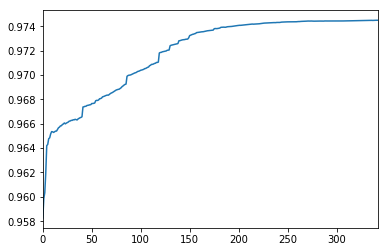

In [14]:
pd.DataFrame(cv_auc)['auc-mean'].plot();

#### Fit final model here

In [56]:
valid_ind = np.random.permutation(N)[:round(N/10)]

In [57]:
valid = d.iloc[d.index[valid_ind]].reset_index(drop=True)
y_valid = y.iloc[y.index[valid_ind]].reset_index(drop=True)

In [58]:
d = d.drop(d.index[valid_ind]).reset_index(drop=True)
y = y.drop(y.index[valid_ind]).reset_index(drop=True)

In [59]:
N = d.shape[0]

In [15]:
ov = Oversample(d.iloc[:N, vars], y.iloc[:N], n_splits=5, seed=SEED)
# ov = Oversample(d.iloc[:10000, vars], y[:10000], n_splits=5, seed=SEED)

indices = ov.generate_all()

gc.collect();

In [16]:
dtrain = lgb.Dataset(d.iloc[indices, vars], label=y.iloc[indices], categorical_feature=categoricals)

start_time = time.time()

model = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, 
                  categorical_feature=categoricals,
                  valid_sets=[dtrain], 
                  early_stopping_rounds=50, 
                  verbose_eval=10)


# del dtrain#, dval
gc.collect()

print('[{}] Finished LGBM Training'.format(time.time() - start_time))

/Users/toniblaslov/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.966873
[20]	training's auc: 0.967571
[30]	training's auc: 0.968708
[40]	training's auc: 0.969118
[50]	training's auc: 0.969609
[60]	training's auc: 0.970891
[70]	training's auc: 0.971668
[80]	training's auc: 0.9722
[90]	training's auc: 0.9727
[100]	training's auc: 0.973201
[110]	training's auc: 0.973654
[120]	training's auc: 0.974705
[130]	training's auc: 0.975533
[140]	training's auc: 0.975938
[150]	training's auc: 0.976572
[160]	training's auc: 0.976938
[170]	training's auc: 0.977155
[180]	training's auc: 0.977647
[190]	training's auc: 0.977918
[200]	training's auc: 0.978121
[210]	training's auc: 0.978347
[220]	training's auc: 0.97859
[230]	training's auc: 0.9788
[240]	training's auc: 0.978951
[250]	training's auc: 0.979149
[260]	training's auc: 0.979311
[270]	training's auc: 0.979464
[280]	training's auc: 0.979585
[290]	training's auc: 0.979722
[300]	training's auc: 0.97985
[310]	training's auc: 0.9

In [63]:
pred_val = model.predict(valid.loc[:, vars_name])

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

In [65]:
cv_auc_mean = roc_auc_score(y_valid, pred_val)
cv_auc_mean

0.9743771914502644

#### Score and save to outputs

In [17]:
gc.collect();

In [18]:
test2 = pd.read_csv(os.path.join(DATA, 'raw', 'test.csv'),
                usecols=['click_id'])

In [ ]:
y_test = model.predict(test.loc[:,vars_name])

In [21]:
d_sub = pd.DataFrame({'click_id': test2.click_id, 'is_attributed': y_test})

In [31]:
test.head()

,ip,app,device,os,channel,quarter,time,date,day_of_week,week,n_ip_day_of_week_quarter_channel,n_ip_quarter_app_app,n_ip_quarter_device_device,n_ip_quarter_os_os,n_ip_quarter_channel_channel
0,5744,9,1,3,107,21,14400,20171110,4,45,7,2,7,2,1
1,119901,9,1,3,466,21,14400,20171110,4,45,100,16,99,8,3
2,72287,21,1,19,128,21,14400,20171110,4,45,47,2,47,8,2
3,78477,15,1,13,111,21,14400,20171110,4,45,61,3,61,25,1
4,123080,12,1,13,328,21,14400,20171110,4,45,25,2,25,19,2


In [20]:
y_test = model.predict(test.loc[:,vars_name])

In [67]:
d_sub = pd.DataFrame({'click_id': range(len(y_test)), 'is_attributed': y_test})

In [34]:
# y_test = model.predict(test.loc[:,vars])

In [22]:
output_name = os.path.join(OUTPUT, NAME + '-' + str(cv_auc_mean))

d_sub.to_csv(output_name + '.csv', index=False)
# feather.write_dataframe(d_sub, output_name + '.feather')

#### Save the model to disk

In [23]:
import pickle
with open(os.path.join(ROOT, 'models', NAME + '.pickle'), 'wb') as file:
    pickle.dump(model, file)